In [1]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider
import sounddevice as sd

# Constant parameters
PI = np.pi
speed_of_sound = 343.0
elem_distance = 0.042

# Audio parameters
Fs       = 44100
F0       = speed_of_sound / elem_distance      # probe frequency, why this frequency?
npt      = 128*1024 # per channel
dur      = npt/Fs
nchan    = 16

# Configure Audio devices
print(sd.query_devices())
dev_in = sd.query_devices("micArray16")
dev_out = sd.query_devices("default") # for Black USB-cable speaker
input_device_id = dev_in['index']
output_device_id = dev_out['index']
print(f"Found devices: in:{input_device_id} out:{output_device_id}")
sd.default.samplerate = Fs
sd.default.channels = nchan
sd.default.device = [input_device_id, output_device_id]


  0 nanoSHARC micArray16 UAC2.0: USB Audio (hw:2,0), ALSA (16 in, 0 out)
  1 pulse, ALSA (32 in, 32 out)
* 2 default, ALSA (32 in, 32 out)
Found devices: in:0 out:2


Probe frequency:  1440
Filtering for frequency:  1440
Normalizing samples


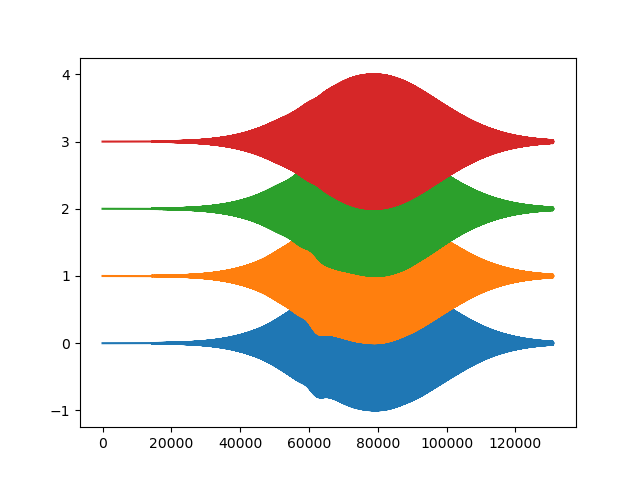

In [59]:
# Generate 3 second signal
import numpy as np
from signals import PulseWave
from filters import BandpassFilter, Normalize

def probe(freq = F0, filt = True, normalize = True):
    outsmp = PulseWave(npt, Fs, freq, amp=0.2)

    # play & record with 16 mics
    insmp = sd.playrec(outsmp, samplerate=Fs)
    sd.wait()

    signals = np.zeros((4, len(insmp[:,0])))
    signals[0] = insmp[:, 1]  + insmp[:, 3] + insmp[:, 5] + insmp[:, 7]
    signals[1] = insmp[:, 0] + insmp[:, 2] + insmp[:, 4] + insmp[:, 6]
    signals[2] = insmp[:, 15]  + insmp[:, 13] + insmp[:, 11] + insmp[:, 9]
    signals[3] = insmp[:, 14] + insmp[:, 12] + insmp[:, 10] + insmp[:, 8]

    if filt:
        print("Filtering for frequency: ", freq)
        signals = BandpassFilter(signals, Fs, freq, 300)  
    if normalize:
        print("Normalizing samples");
        signals = Normalize(signals)
    return signals

# Select two microphones to compare, one left and one right
# mic_dist = 3*elem_distance # mic 2 & 15 are 3 units apart
freq = 1440
print("Probe frequency: ", freq)
signals = probe(freq)
# Column 1: 8+6+4+2, Column 2: 7+5+3+1, Column 3: 10+12+14+16, Column 4: 9+11+13+15

plt.close("all")
for ch in range(0, 4):
    plt.plot(signals[ch] + ch, '-')
plt.show()

Start calculating Power for each angle
Done.


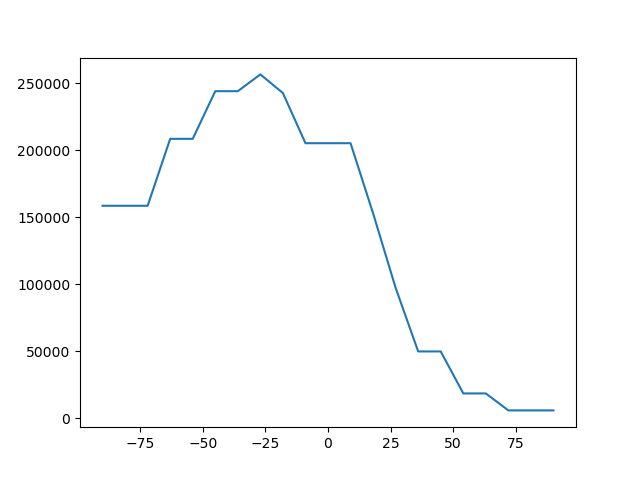

Maximum at angle: -27.0 degrees


In [68]:

def angle2shift(angle):
    angle_rad = np.radians(angle)
    # length difference due to angle-of-incidence
    shift_distance = elem_distance * np.sin(angle_rad)
    # Time difference when sound travels this distance
    shift_time = shift_distance / speed_of_sound
    # Amount of samples in that time
    shift_samples = shift_time * Fs
    return shift_samples

def calc_power(signals, shift):
    shift = int(shift)
    numc = signals.shape[0]
    nums = signals.shape[1]
    power = 0
    
    # print(f"{numc=} {nums=} {nums + shift*(numc-1)=}")
    for n in range(0, nums + abs(shift)*(numc-1)):
        # print(f"row: {n}",)
        s = 0
        for ch in range(0, numc):
            if shift >= 0:
                chshift = shift*ch
            else:
                chshift = -1*shift*(numc - 1 - ch)
            idx = n - chshift
            if idx < 0:
                # print(f"s += signals[{ch=}][{idx=}] = 0")
                continue
            if idx > nums - 1:
                # print(f"s += signals[{ch=}][{idx=}] = 0")
                continue
            # print(f"s += signals[{ch=}][{idx=}] = ", signals[ch, idx])
            s += signals[ch, idx]
        # print(f"Sum = {s=}\n")
        power += np.power(s, 2)
    return power        
    
def plot_direction(signals):
    angles = np.linspace(-90, 90, 21)
    shifts = angle2shift(angles)
    print("Start calculating Power for each angle")
    sum_samples = [calc_power(signals, shift) for shift in shifts]
    print("Done.")

    plt.close("all")
    plt.plot(angles, sum_samples)
    plt.show()    

    angle_of_max = angles[np.argmax(sum_samples)]
    print(f"Maximum at angle: {angle_of_max} degrees")
        
# # As a start we will choose a wavelength of twice the microphone distance: now the signal will cancel out at 90 degree angels
# freq = speed_of_sound / elem_distance / 2 / 2
# # freq = 700
# print("Probe frequency: ", freq)
# insmp = probe(freq)

# signals = np.array([
#              [1, 2, 3, 4], 
#           [1, 2, 3, 4], 
#        [1, 2, 3, 4], 
#     [1, 2, 3, 4]])
#-1= 1  3  6 10  9  7  4
# 0= 4  8 12 16
# 1= 1  3  6 10  9  7  4
# 2= 1  2  4  6  4  6  4  6  3  4
# 3= 1  2  3  5  2  3  5  2  3  5  2  3  4
# calc_power(signals, -1)
# calc_power(signals, 0)
# calc_power(signals, 1)
# calc_power(signals, 2)
# calc_power(signals, 3)

plot_direction(signals)
